In [ ]:
# EXCERPTS FROM CCPD code and "Enhancing-oct-image-resolution-with-srgan" code

In [1]:
# install an older version of tensorflow 
# (the implementation may not work with the most recent TensorFlow release)

!pip install keras==2.3.1
!pip3 install tensorflow==2.8 --use-deprecated=legacy-resolver
#!pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.9.0-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 6.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.3.1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os
import gc
import shutil
import time
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

from keras import Input
from keras.applications.vgg19 import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
from numba import cuda

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.8.0
Keras version 2.8.0


In [24]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
#BASE_PATH = "/kaggle/input/chinese-city-parking-dataset-eccv/CCPD2019/"
BASE_PATH = r'../input/ccpd-preprocess/CCPD2019/ccpd_base/'

# data path
#TRAIN_PATH = r'../input/kermany2018/OCT2017 /train/'
#VAL_PATH = r'../input/kermany2018/OCT2017 /val/'
#TEST_PATH = r'../input/kermany2018/OCT2017 /test/'
data_path = BASE_PATH

epochs = 11

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (256, 256, 3)   # (64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

# DATA PROCESSSING

In [4]:
def get_train_images(data_path):

    CLASSES = ["ccpd_base"]#, "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
    image_list = []

    #for class_type in CLASSES:
    #sub_path = os.path.join(BASE_PATH, class_type)
    sub_files = os.listdir(BASE_PATH)
    #print(sub_path)
    for file in sub_files:
        image_list.append(file)
    
    # image_list contains the list of filenames of all images
    return image_list  

In [5]:
def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size()))
        max_size.append(max(im.size()))
    
    return min(min_size), max(max_size)

In [6]:
# get min/max image sizes

image_list = get_train_images(data_path)
'''min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))'''

"min_size, max_size = find_img_dims(image_list)\nprint('The min and max image dims are {} and {} respectively.'\n      .format(min_size, max_size))"

In [7]:
len(image_list)

199996

In [9]:
# function to preprocess image so that it can be handled by model
def preprocess_image(image_path):
   '''Loads the image given make it ready for 
      the model
      Args:
        image_path: Path to the image file
   '''
   image = tf.image.decode_image(tf.io.read_file(image_path))
   if image.shape[-1] == 4:
     image = image[...,:-1]
   size = (tf.convert_to_tensor(image.shape[:-1]) // 4) * 4
   image = tf.image.crop_to_bounding_box(image, 0, 0, size[0], size[1])
   image = tf.cast(image,tf.float32)
   return tf.expand_dims(image,0)

def save_image(image,filename):
  ''' 
   Saves unscaled Tensor Images
   image: 3D image Tensor
   filename: Name of the file to be saved
  '''
  if not isinstance(image, Image.Image):
      image = tf.clip_by_value(image, 0, 255)
      image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save('%s.jpg' % filename)
  print('Saved as %s.jpg' % filename)

## Sampling & Saving Images

In [52]:
def apply_motion_blur(image):
    '''# Check if image_path is a string
    if not isinstance(image_path, str):
        raise TypeError("image_path should be a string representing the file path to the image")
    
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The file '{image_path}' does not exist")'''

    # Read the image
    #    image = cv2.imread(str(image_path))

    # Define a motion blur kernel
    kernel_size = 5
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size

    # Apply the motion blur using cv2.filter2D()
    motion_blurred_image = cv2.filter2D(image, -1, kernel)
    
    return motion_blurred_image

In [53]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, mode='RGB', pilmode='RGB')
        
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
        img1_low_resolution = apply_motion_blur(img1_low_resolution)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
            
        # Apply motion blur to low-resolution image
        img1_low_resolution_blurred = apply_motion_blur(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution_blurred)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [54]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    

## SRGAN VGG16 FRAMEWORK

#### Generator

In [13]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [26]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (256, 256, 3)   #(64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=1)(gen3)   #2
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=1)(gen4)   #2
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

In [27]:
generator = build_generator()

#### DISCRIMINATOR

In [16]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [17]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

#### VGG19 FEATURE EXTRACTOR

In [18]:
VGG19_base = VGG19(weights="imagenet",include_top=False)

80150528/80134624 [==============================] - 0s 0us/step


In [19]:
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base = VGG19(weights="imagenet",include_top=False, input_shape=input_shape)
    output_layer = VGG19_base.get_layer('block5_conv2').output
    model = Model(inputs=VGG19_base.input, outputs=output_layer)    
    
    return model


'''
# last try 
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base = VGG19(weights="imagenet",include_top=False, input_shape=input_shape)
    output_layer = VGG19_base.get_layer('block5_conv2').output
    #VGG19_base.outputs = [VGG19_base.layers[9].output]
    #VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    #input_layer = Input(shape=input_shape)
    #features = VGG19_base(input_layer)
    model = Model(inputs=VGG19_base.input, outputs=output_layer)
    #model = Model(inputs=[input_layer], outputs=[features])
    
    
    return model'''


"""
def build_VGG19():
    input_shape = (256, 256, 3)
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]
    input_layer = Input(shape=input_shape)
    features = vgg(input_layer)    
    model = Model(inputs=[input_layer], outputs=[features])
    return model
    
def build_VGG19():
    input_shape = (256, 256, 3)
    
    # Load pre-trained VGG19 model without the fully connected layers (include_top=False)
    VGG19_base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    
    # Get the output of a specific layer in the VGG19 model
    output_layer = VGG19_base.get_layer('block5_conv2').output
    
    # Create a new model that takes input from input_layer and outputs from output_layer
    model = Model(inputs=VGG19_base.input, outputs=output_layer)
    
    return model
    """

'\ndef build_VGG19():\n    input_shape = (256, 256, 3)\n    vgg = VGG19(weights="imagenet")\n    vgg.outputs = [vgg.layers[9].output]\n    input_layer = Input(shape=input_shape)\n    features = vgg(input_layer)    \n    model = Model(inputs=[input_layer], outputs=[features])\n    return model\n    \ndef build_VGG19():\n    input_shape = (256, 256, 3)\n    \n    # Load pre-trained VGG19 model without the fully connected layers (include_top=False)\n    VGG19_base = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)\n    \n    # Get the output of a specific layer in the VGG19 model\n    output_layer = VGG19_base.get_layer(\'block5_conv2\').output\n    \n    # Create a new model that takes input from input_layer and outputs from output_layer\n    model = Model(inputs=VGG19_base.input, outputs=output_layer)\n    \n    return model\n    '

In [20]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [48]:
from skimage.transform import resize

def resize_image(image, new_shape=(None, 256, 256, 3)):
    new_image = np.zeros(new_shape, dtype=np.uint8)
    for i, img in enumerate(image):
        # resize the image and assign it to new_image
        new_image[i] = resize(img, new_shape[1:], preserve_range=True).astype(np.uint8)
    return new_image


In [49]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    new_shape=(None, 256, 256, 3)
    generated_high_resolution_images = generator(input_low_resolution)
    
    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model


In [50]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

#### TRAINING

In [23]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

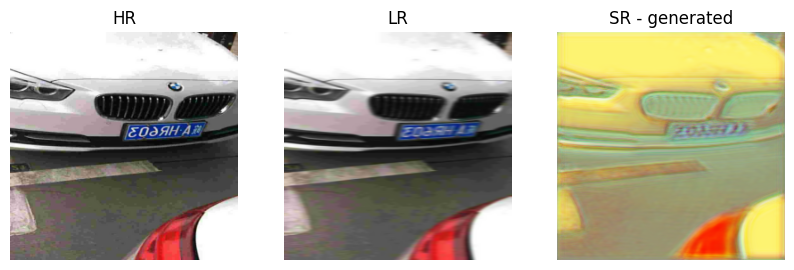

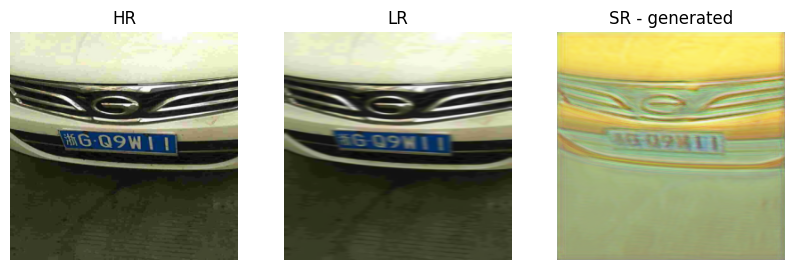

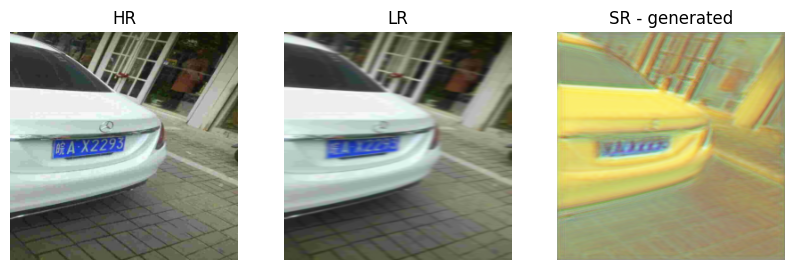

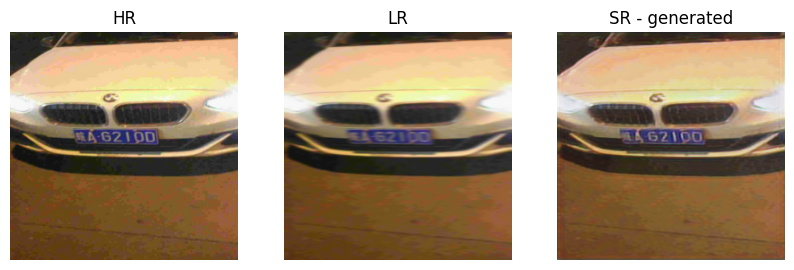

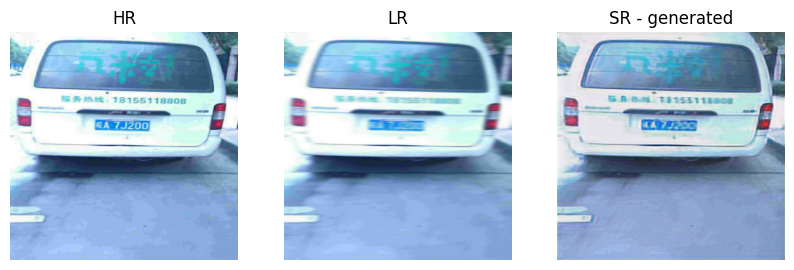

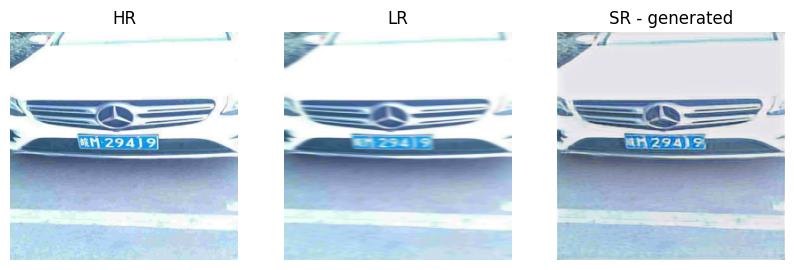

In [56]:
# training loop
epochs = 302

for epoch in range(epochs):
    
    print(epoch)
    

    d_history = []
    g_history = []
    
    K_PATH =  '/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_base/'
    
    image_list_no_path = get_train_images(data_path)
    
    image_list = [BASE_PATH + img_name for img_name in image_list_no_path]
    
    """
    Train the discriminator network
    """
    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)


    
    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images],
                                               [real_labels, image_features])
    
    losses['g_history'].append(0.5 * (g_loss[1]))
    
 
    
    if epoch % 300 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 3:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/kaggle/working/img_{}_{}".format(epoch, index))  

In [57]:
# save model weights

generator.save_weights("/kaggle/working/srgan_generator.h5")
discriminator.save_weights("/kaggle/working/srgan_discriminator.h5")

In [58]:
generator.save('/kaggle/working/srgan_generator_with_json.h5', save_format='h5')
discriminator.save('/kaggle/working/srgan_discriminator_with_json.h5', save_format='h5')

In [59]:
import json

# Save the model's architecture as a JSON string
discriminator_config = discriminator.to_json()

# Write the model_config to a file
with open('discriminator_config.json', 'w') as json_file:
    json_file.write(discriminator_config)

'''# Now reload the model
with open('model_config.json', 'r') as json_file:
    model_config = json_file.read()

reloaded_model = keras.models.model_from_json(model_config)'''

"# Now reload the model\nwith open('model_config.json', 'r') as json_file:\n    model_config = json_file.read()\n\nreloaded_model = keras.models.model_from_json(model_config)"

In [1]:
generated_images = generator.predict_on_batch(lr_images)

NameError: name 'generator' is not defined

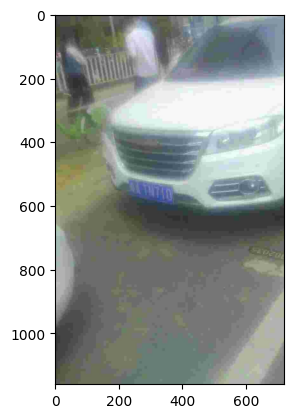

In [60]:
fig, axs = plt.subplots(1, 1)

inp_path =  '/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_blur/'

#for sub in list_sub:
#sub_path = os.path.join(BASE_PATH, "ccpd_blur")
sub_files = os.listdir(inp_path)[0:5]
file_name = os.path.join(inp_path, sub_files[4])
image = plt.imread(file_name)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [61]:
model_new = tf.keras.models.load_model('/kaggle/working/srgan_generator_with_json.h5')

In [62]:
CLASSES = ["ccpd_base"]#, "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
test_image_list = []

inp_path =  '/kaggle/input/ccpd-preprocess/CCPD2019/ccpd_blur/'

#for class_type in CLASSES:
#sub_path = os.path.join(BASE_PATH, class_type)
sub_files = os.listdir(inp_path)
#print(sub_path)
for file in sub_files:
    test_image_list.append(file)

In [71]:
len(test_image_list)

20611

In [1]:
test_image_list_path = [inp_path + img_name for img_name in test_image_list]

hr_images, lr_images = sample_images(test_image_list_path, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)

hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.
    
    
generated_images = model_new.predict(hr_images)
#generated_images2 = model_new.predict(generated_images)
 
for index, img in enumerate(generated_images):
    if (index < 8):   # comment this line to display all the images
        save_images(hr_images[index], lr_images[index], img,path="/kaggle/working/img_{}_{}".format(1000, index))  

NameError: name 'test_image_list' is not defined

In [ ]:
import cv2

# Define the input file path
input_image_path = 'input_image.jpg'

# Load the image using the file path
image = cv2.imread(input_image_path)

# Upsample the image to (256, 256) using bicubic interpolation
upsampled_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)

# Save the upsampled image
output_image_path = 'output_image.jpg'
cv2.imwrite(output_image_path, upsampled_image)


In [ ]:
mid_resolution_shape = (128, 128, 3)

In [ ]:
'''
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, mode='RGB', pilmode='RGB')
        
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    '''

In [ ]:
# Unecessary   
    """"
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)

    
  
    
        save and print image samples
    """